## Import Libraries and Functions

### Libraries

In [177]:
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import squarify

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.cluster import KMeans

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### functions

In [19]:
def month_trunc(x):
    return dt.datetime(x.year,x.month,1)

## Read Data

In [68]:
online = pd.read_csv('customer_segmentation/chapter_1/online.csv',index_col=0)
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom
482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom
263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom
495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom
204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom


In [69]:
online=online.reset_index(drop=True)
online.columns = ['invoice_no','stock_code','description','quantity',
                  'invoice_date','unit_price','customer_id','country']

#online['unit_price'] = [float(k.replace(',','.')) for k in online['unit_price']]
online['invoice_date'] = pd.to_datetime(online['invoice_date'])
#online['customer_id'] = online['customer_id'].fillna('no customer')

online.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom
1,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom
2,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom
3,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom
4,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom


## Cohort Analysis

### Perform time cohort analysis based on time (monthly)

In [70]:
##truncate data
online['invoice_month'] = online['invoice_date'].apply(month_trunc)

In [71]:
## Calculate the first purchase for each customer
online['cohort_month'] = online.groupby('customer_id')['invoice_month'].transform('min')

In [72]:
##Calculate elapsed tim esince first purchase in months
online['cohort_index'] = [int(k.days/30)+1 for k in (online['invoice_month'] - online['cohort_month'])]
online.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,invoice_month,cohort_month,cohort_index
0,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom,2011-10-01,2011-04-01,7
1,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom,2011-11-01,2011-09-01,3
2,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom,2011-07-01,2011-07-01,1
3,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom,2011-11-01,2011-11-01,1
4,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom,2011-05-01,2011-02-01,3


In [95]:
### Create cohort table
query = (online.groupby(['cohort_month','cohort_index'])['customer_id']
         .apply(pd.Series.nunique)
         .reset_index()
         .pivot(index='cohort_month',columns='cohort_index',values='customer_id')
         .sort_index())

##get percentage
total = query.sum(axis=0)
total.name = 'total'
query=query.append(total)

cohort_total = query.iloc[:,0]

query = query.divide(cohort_total,axis=0).round(2)
query

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort_month,,,,,,,,,,,,,
2010-12-01 00:00:00,1.0,0.34,0.31,0.35,0.34,0.40,0.35,0.33,0.34,0.37,0.35,0.49,0.24
2011-01-01 00:00:00,1.0,0.36,NaN,0.24,0.33,0.27,0.25,0.26,0.31,0.31,0.37,0.14,NaN
2011-02-01 00:00:00,1.0,0.18,0.26,NaN,0.27,0.23,0.25,0.26,0.27,0.30,0.09,NaN,NaN
2011-03-01 00:00:00,1.0,0.16,0.26,0.20,0.21,0.17,0.25,0.22,0.28,0.10,NaN,NaN,NaN
2011-04-01 00:00:00,1.0,0.19,0.20,0.19,0.18,0.20,0.22,0.23,0.07,NaN,NaN,NaN,NaN
2011-05-01 00:00:00,1.0,0.16,0.17,0.14,0.21,0.23,0.24,0.09,NaN,NaN,NaN,NaN,NaN
2011-06-01 00:00:00,1.0,0.16,0.13,0.20,0.24,0.30,0.09,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01 00:00:00,1.0,0.16,0.18,0.22,0.25,0.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01 00:00:00,1.0,0.22,0.20,0.25,0.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'Total Retention Rate')

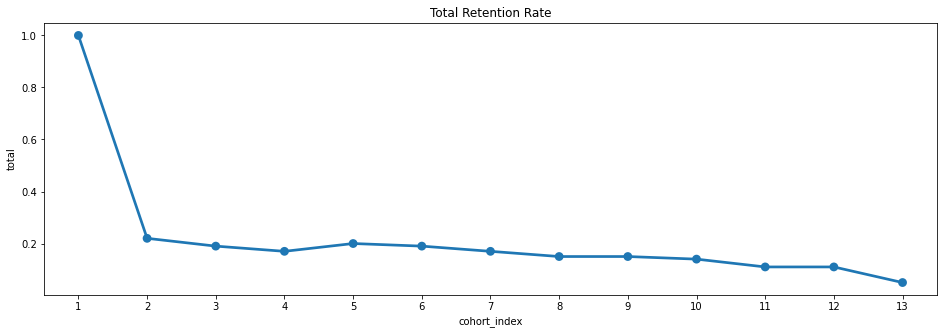

In [107]:
##plot total retention
fig=plt.figure(figsize=(16,5))
plt.title('Total Retention Rate')
sns.pointplot(y=query.loc['total'],x=query.columns)
plt.show()

<Figure size 1152x576 with 0 Axes>

Text(0.5, 1.0, 'Retention Rates')

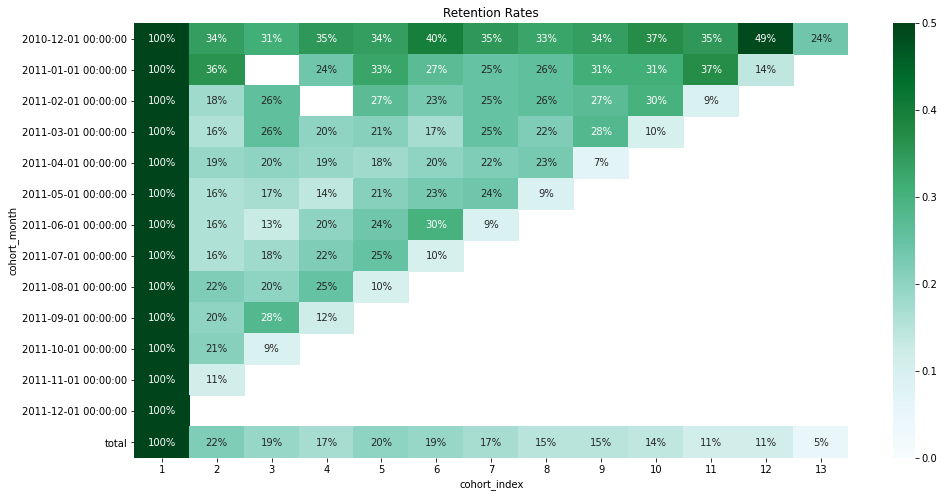

In [108]:
##plot information
plt.figure(figsize=(16,8))
plt.title('Retention Rates')

sns.heatmap(data=query,annot=True,cmap='BuGn',fmt='.0%',vmin=0.0,vmax=0.5)

### FROM DATACAMP

In [77]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

invoice_year, invoice_month, _ = get_date_int(online,'invoice_month')
cohort_year, cohort_month, _ = get_date_int(online,'cohort_month')
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month
online['CohortIndex'] = years_diff * 12 + months_diff + 1
online.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,invoice_month,cohort_month,cohort_index,CohortIndex
0,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom,2011-10-01,2011-04-01,7,7
1,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom,2011-11-01,2011-09-01,3,3
2,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom,2011-07-01,2011-07-01,1,1
3,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom,2011-11-01,2011-11-01,1,1
4,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom,2011-05-01,2011-02-01,3,4


## RFM

recency, frequency, monetary value

In [140]:
online = pd.read_csv('customer_segmentation/chapter_2/online12M.csv',index_col=0)
online=online.reset_index(drop=True)
online.columns = ['invoice_no','stock_code','description','quantity',
                  'invoice_date','unit_price','customer_id','country']

#online['unit_price'] = [float(k.replace(',','.')) for k in online['unit_price']]
online['invoice_date'] = pd.to_datetime(online['invoice_date'])
#online['customer_id'] = online['customer_id'].fillna('no customer')

online.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25,2.10,14286,United Kingdom
1,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20,1.45,16360,United Kingdom
2,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14,3.75,13933,United Kingdom
3,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23,2.10,17290,United Kingdom
4,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25,5.95,17663,United Kingdom


In [141]:
## define current date
today = online['invoice_date'].max() + dt.timedelta(days=1)

##get total sum
online['total_sum'] = online['unit_price']*online['quantity']

In [142]:
##calculate RFM
query = (online.groupby('customer_id').agg({
            'invoice_date': (lambda x: (today - x.max()).days),
            'invoice_no':'count',
            'total_sum':'sum'}))
query.columns = ['recency','frequency','monetary']
query.head()

,recency,frequency,monetary
customer_id,,,
12747,3,25,948.70
12748,1,888,7046.16
12749,4,37,813.45
12820,4,17,268.02
12822,71,9,146.15


In [143]:
query.describe()

,recency,frequency,monetary
count,3643.00000,3643.000000,3643.000000
mean,90.43563,18.714247,370.694387
std,94.44651,43.754468,1347.443451
min,1.00000,1.000000,0.650000
25%,19.00000,4.000000,58.705000
50%,51.00000,9.000000,136.370000
75%,139.00000,21.000000,334.350000
max,365.00000,1497.000000,48060.350000


In [144]:
##get quartiles
r = pd.qcut(query['recency'],4,labels=range(4,0,-1))
f = pd.qcut(query['frequency'],4,labels=range(1,5))
m = pd.qcut(query['monetary'],4,labels=range(1,5))
query=query.assign(R=r,F=f,M=m)
query.head()

,recency,frequency,monetary,R,F,M
customer_id,,,,,,
12747,3,25,948.70,4,4,4
12748,1,888,7046.16,4,4,4
12749,4,37,813.45,4,4,4
12820,4,17,268.02,4,3,3
12822,71,9,146.15,2,2,3


In [145]:
query[['R','F','M']].describe()

,R,F,M
count,3643,3643,3643
unique,4,4,4
top,4,1,4
freq,943,1095,911


In [152]:
## get RFM score
query['RFM_score'] = query[['R','F','M']].sum(axis=1)

##get RFM level
def rfm_level(x):
    if x>=9:
        return 'Gold'
    if x>=6:
        return 'Silver'
    return 'Bronze'
query['RFM_level'] = query['RFM_score'].apply(rfm_level)

query.head()
rfm=query.copy(deep=True)

,recency,frequency,monetary,R,F,M,RFM_score,RFM_level
customer_id,,,,,,,,
12747,3,25,948.70,4,4,4,12.0,Gold
12748,1,888,7046.16,4,4,4,12.0,Gold
12749,4,37,813.45,4,4,4,12.0,Gold
12820,4,17,268.02,4,3,3,10.0,Gold
12822,71,9,146.15,2,2,3,7.0,Silver


In [147]:
query['RFM_score'].describe()

count    3643.000000
mean        7.424376
std         2.815385
min         3.000000
25%         5.000000
50%         7.000000
75%        10.000000
max        12.000000
Name: RFM_score, dtype: float64

In [148]:
list(query['RFM_level'].value_counts().values)

[1366, 1202, 1075]

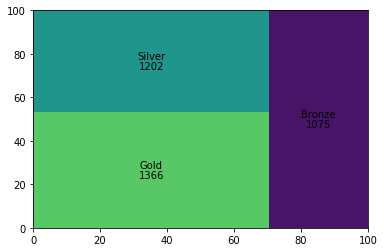

In [149]:
squarify.plot(label=list(query['RFM_level'].value_counts().index),
              sizes=list(query['RFM_level'].value_counts().values),
              value=list(query['RFM_level'].value_counts().values))

## Cluster Analysis

In [273]:
rfm = pd.read_csv('customer_segmentation/chapter_4/datamart_rfm.csv')
rfm .columns = ['customer_id','recency','frequency','monetary']
rfm=rfm.set_index('customer_id')
rfm.head()

,recency,frequency,monetary
customer_id,,,
12747,3,25,948.70
12748,1,888,7046.16
12749,4,37,813.45
12820,4,17,268.02
12822,71,9,146.15


### Prepare data to apply k means

Some assumptions:

- data should be close to normal - not skewed
- The mean and standard deviation of the features should be similar

obs: Has to be addressed in this order

In [274]:
srfm = rfm[['recency','frequency','monetary']]
srfm.head()

,recency,frequency,monetary
customer_id,,,
12747,3,25,948.70
12748,1,888,7046.16
12749,4,37,813.45
12820,4,17,268.02
12822,71,9,146.15


#### Check and handle normal

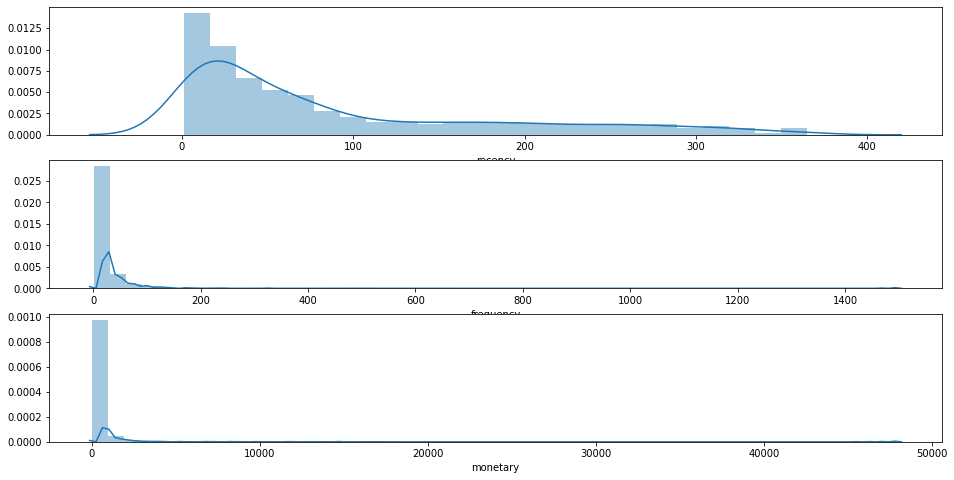

In [275]:
##check distribuitions
fig,axs=plt.subplots(3,1,figsize=(16,8))
sns.distplot(srfm['recency'],ax=axs[0])
sns.distplot(srfm['frequency'],ax=axs[1])
sns.distplot(srfm['monetary'],ax=axs[2])

In [276]:
## Apply log transformation
pt = PowerTransformer(standardize=True) ##if this is set to True, it applies the zero-mean, unit-variance
modified_rfm = pd.DataFrame(pt.fit_transform(srfm),columns=srfm.columns,index=srfm.index)
modified_rfm.head()

,recency,frequency,monetary
customer_id,,,
12747,-1.750517,0.902087,1.451388
12748,-2.121134,3.193234,2.838394
12749,-1.623314,1.212956,1.340401
12820,-1.623314,0.582787,0.519611
12822,0.250442,0.032808,0.056997


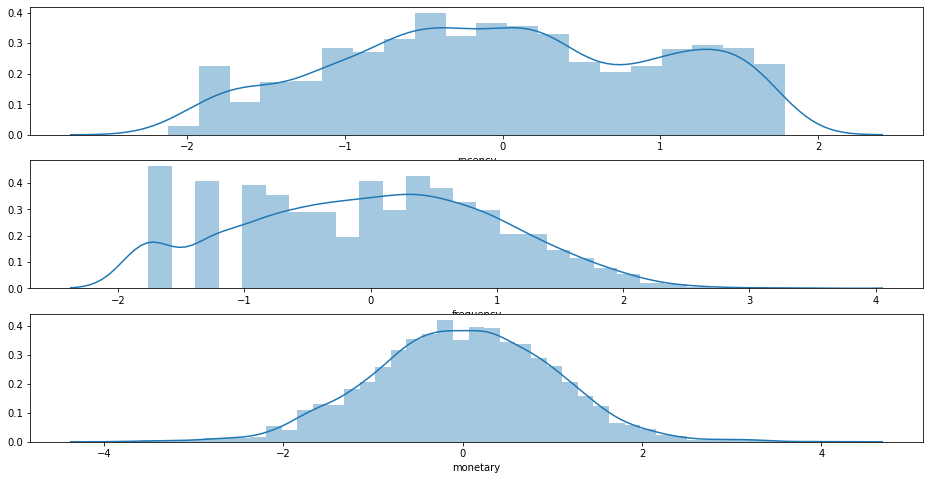

In [277]:
##check distribuitions
fig,axs=plt.subplots(3,1,figsize=(16,8))
sns.distplot(modified_rfm['recency'],ax=axs[0])
sns.distplot(modified_rfm['frequency'],ax=axs[1])
sns.distplot(modified_rfm['monetary'],ax=axs[2])

In [279]:
modified_rfm.describe().round(0)

,recency,frequency,monetary
count,3643.0,3643.0,3643.0
mean,-0.0,0.0,-0.0
std,1.0,1.0,1.0
min,-2.0,-2.0,-4.0
25%,-1.0,-1.0,-1.0
50%,-0.0,0.0,0.0
75%,1.0,1.0,1.0
max,2.0,3.0,4.0


#### FROM DataCamp

In [282]:
datamart_rfm = pd.read_csv('customer_segmentation/chapter_4/datamart_rfm.csv',index_col=0)
datamart_rfm.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12747,3,25,948.70
12748,1,888,7046.16
12749,4,37,813.45
12820,4,17,268.02
12822,71,9,146.15


In [284]:
datamart_log = np.log(datamart_rfm)
scaler = StandardScaler()
scaler.fit(datamart_log)
datamart_normalized = scaler.transform(datamart_log)

d_norm = pd.DataFrame(datamart_normalized,index=datamart_rfm.index,columns=datamart_rfm.columns)
d_norm.describe().round(0)

StandardScaler(copy=True, with_mean=True, with_std=True)

,Recency,Frequency,MonetaryValue
count,3643.0,3643.0,3643.0
mean,-0.0,0.0,0.0
std,1.0,1.0,1.0
min,-3.0,-2.0,-4.0
25%,-1.0,-1.0,-1.0
50%,0.0,0.0,-0.0
75%,1.0,1.0,1.0
max,2.0,4.0,4.0


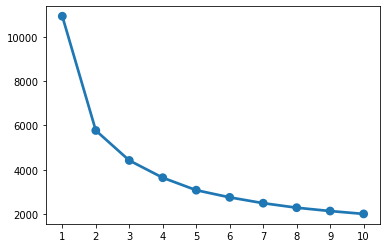

In [286]:
sse = [KMeans(n_clusters=k).fit(datamart_normalized).inertia_ for k in range(1,11)]
sse = pd.Series(sse,index=range(1,11))

sns.pointplot(y=sse.values,x=sse.index)

### Apply the clustering method

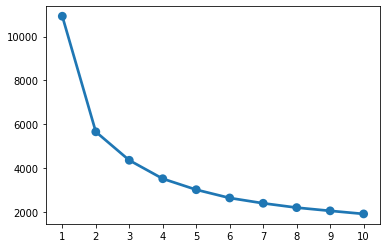

In [288]:
#### Select number of clusters using elbow method

sse = [KMeans(n_clusters=k).fit(modified_rfm.values).inertia_ for k in range(1,11)]
sse = pd.Series(sse,index=range(1,11))

sns.pointplot(y=sse.values,x=sse.index)

In [296]:
### apply kmeans with number of clusters chosen
labels2 = KMeans(n_clusters=2).fit(modified_rfm.values).labels_
rfm.groupby(labels2).agg({
    'recency':'mean',
    'frequency':'mean',
    'monetary':['mean','count']
}).round(0)

recency frequency monetary      
     mean      mean     mean count
0    34.0      34.0    679.0  1744
1   143.0       5.0     88.0  1899

In [297]:
### apply kmeans with number of clusters chosen
labels3 = KMeans(n_clusters=3).fit(modified_rfm.values).labels_
rfm.groupby(labels3).agg({
    'recency':'mean',
    'frequency':'mean',
    'monetary':['mean','count']
}).round(0)

recency frequency monetary      
     mean      mean     mean count
0    78.0      11.0    192.0  1515
1    20.0      47.0    962.0  1043
2   176.0       3.0     52.0  1085

#### Analyze clusters and compare with RFM

In [298]:
modified_rfm['cluster'] = labels3
modified_rfm.head()

,recency,frequency,monetary,cluster
customer_id,,,,
12747,-1.750517,0.902087,1.451388,1
12748,-2.121134,3.193234,2.838394,1
12749,-1.623314,1.212956,1.340401,1
12820,-1.623314,0.582787,0.519611,1
12822,0.250442,0.032808,0.056997,0


In [299]:
snake = pd.melt(modified_rfm.reset_index(),
               id_vars=['customer_id','cluster'],
               value_vars=['recency','frequency','monetary'],
               var_name='attr',
               value_name='value')
snake.head()

,customer_id,cluster,attr,value
0,12747,1,recency,-1.750517
1,12748,1,recency,-2.121134
2,12749,1,recency,-1.623314
3,12820,1,recency,-1.623314
4,12822,0,recency,0.250442


Text(0.5, 1.0, 'Snake plot of standardized variables')

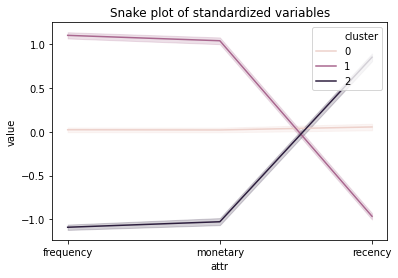

In [300]:
plt.title('Snake plot of standardized variables')
sns.lineplot(x="attr", y="value", hue='cluster', data=snake)

In [310]:
##get cluster importance
cluster_avg = rfm.groupby(labels3).mean()
pop_avg = rfm.mean()
rel_importance = (cluster_avg/pop_avg) -1
rel_importance = rel_importance[['frequency','monetary','recency']]
rel_importance.head()

,frequency,monetary,recency
0,-0.424875,-0.483260,-0.135713
1,1.492244,1.596379,-0.781541
2,-0.841221,-0.859802,0.940785


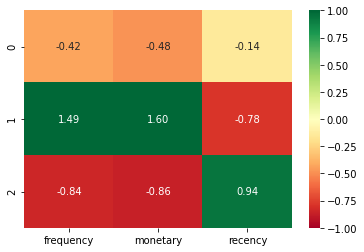

In [311]:
sns.heatmap(data=rel_importance,annot=True,fmt='.2f',cmap='RdYlGn',vmax=1,vmin=-1)